In [6]:
import re
import pandas as pd
import spacy
from collections import Counter
from stop_words import get_stop_words
from splitter.functions import *
import networkx as nx
import community

with open("/home/james/workspace/religion/texts/bible/00_﻿The_First_Book_of_Moses.txt") as f:
    book = f.read()

In [7]:


cleaned_book = clean_text(book.replace('\ufeff','').replace('\n',' '), spaces=True)

stop_words = get_stop_words('en')
pattern = re.compile(r'\b(' + r'|'.join(stop_words) + r')\b\s*')
cleaned_book = pattern.sub('', cleaned_book.lower())

lines = re.split(r'[0-9]+:[0-9]+ ', cleaned_book)[1:]

In [8]:

nlp = spacy.load('en')

def get_pos(line):
    pos = ['NOUN', 'PROPN']
    doc = nlp(line)
    nouns = Counter([word.text for word in doc if word.pos_ in pos])
    
    return nouns

nouns_per_line = [get_pos(line) for line in lines]

In [9]:
from functools import reduce
nouns = reduce(lambda x, y: x+y,[list(line.keys()) for line in nouns_per_line])
counts = Counter(nouns)

df = pd.Series(counts).sort_values(ascending=False).to_frame()
df.columns = ['count']
df = df[df['count'] > 25]

ax = df.plot()

In [10]:
from itertools import combinations

def get_weight(i, subset):
    noun_dict = nouns_per_line[i]
    return noun_dict[subset[0]]*noun_dict[subset[1]]

tot_edges = pd.DataFrame()

for i in range(len(nouns_per_line)): 
    edges = pd.DataFrame([
        subset + (get_weight(i,subset),)
        for subset in combinations(nouns_per_line[i], 2)
        if subset[0] in df.index and subset[1] in df.index
    ])    
    tot_edges = tot_edges.append(edges)

tot_edges.columns = ['node_1','node_2','weight']
tot_edges = tot_edges.reset_index().drop('index',axis=1)

In [11]:
# Initialize Graph
G = nx.Graph()

# Get list of possible nodes
node_from = tot_edges['node_1'].unique()
node_to = tot_edges['node_2'].unique()

nodes = list(set().union(node_from,node_to))
G.add_nodes_from(nodes)

# Add From and To Edges
for i, record in tot_edges.iterrows():
    u = record['node_1']
    v = record['node_2']
    weight = record['weight']
    
    if G.has_edge(u,v):
        G[u][v]['weight'] = G[u][v]['weight']+ weight
    else:
        G.add_edge(u,v, weight=weight)


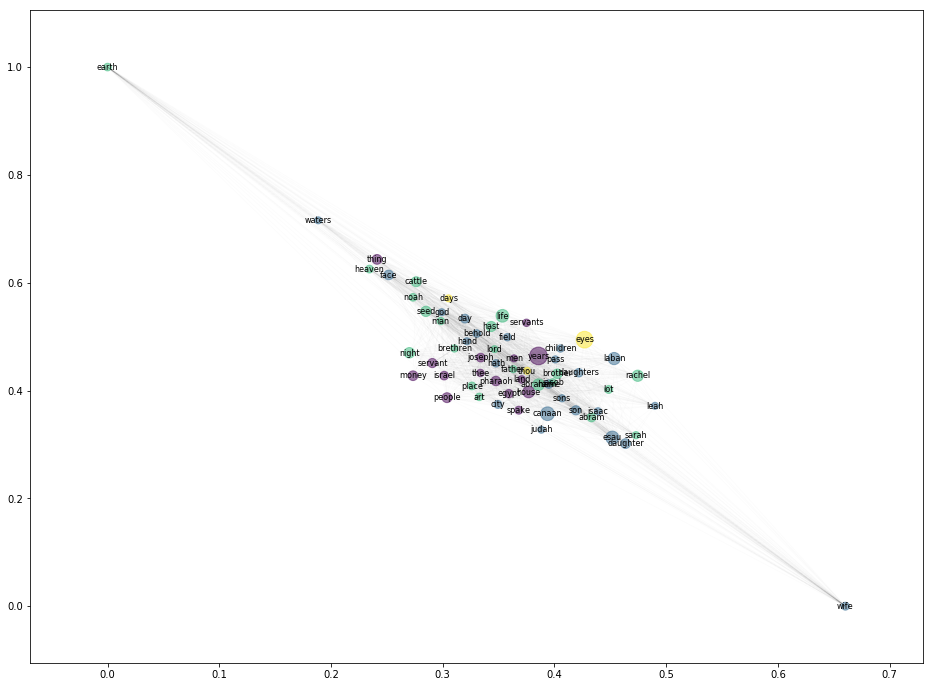

In [20]:
from networkx.drawing.layout import fruchterman_reingold_layout

%matplotlib inline
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(16, 12))

pos = fruchterman_reingold_layout(G)
bt = nx.betweenness_centrality_source(G, normalized=True, weight='weight', sources=nodes)
parts = community.best_partition(G)

node_sizes = [ 100000*x*x+50 for x in list(bt.values())]
community_colors = list(parts.values())

nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=community_colors, alpha=0.5, line_color=None)
nx.draw_networkx_edges(G, pos, alpha=0.01, style='solid')

nodes = G.nodes()
ax = nx.draw_networkx_labels(G, pos, {node: node for node in nodes},font_size=8)

In [25]:
communes = pd.Series(parts).to_frame().reset_index()
communes.columns = ['word','community']

communes[communes['community'] == 1]

,word,community
0,abraham,1
1,abram,1
5,brother,1
8,children,1
9,city,1
10,daughter,1
11,daughters,1
16,esau,1
20,field,1
27,isaac,1


In [29]:
import plotly
from plotly.plotly import plot, iplot
from plotly.graph_objs import Scatter3d, Line, Layout, Marker, Scene, XAxis, YAxis, ZAxis, Margin, Annotation, Annotations, Font, Data, Figure

pos = nx.fruchterman_reingold_layout(G,dim=3)
pos_vals = list(pos.values())
N=len(G.nodes())

Xn=[pos_vals[k][0] for k in range(N)]# x-coordinates of nodes
Yn=[pos_vals[k][1] for k in range(N)]# y-coordinates
Zn=[pos_vals[k][2] for k in range(N)]# z-coordinates

# Set up edge layout
Xe=[]
Ye=[]
Ze=[]

for e in G.edges():
    Xe+=[pos[e[0]][0],pos[e[1]][0], None]
    Ye+=[pos[e[0]][1],pos[e[1]][1], None]
    Ze+=[pos[e[0]][2],pos[e[1]][2], None]

trace1=Scatter3d(x=Xe,
               y=Ye,
               z=Ze,
               mode='lines',
               line=Line(color='rgb(125,125,125)', width=0.05, dash=True),
               hoverinfo='none'
               )

trace2=Scatter3d(x=Xn,
               y=Yn,
               z=Zn,
               mode='markers',
               name='callers',
               marker=Marker(symbol='dot',
                             size= [ 100*x +5 for x in list(bt.values())],
                             color=community_colors,
                             colorscale='Rainbow',
                             opacity=0.5
                             ),
               text=G.nodes(),
               hoverinfo='text'
               )

axis=dict(showbackground=False,
          showline=False,
          zeroline=False,
          showgrid=False,
          showticklabels=False,
          title=''
          )
layout = Layout(
         title="Bible character relations",
         width=1000,
         height=1000,
         showlegend=False,
         scene=Scene(
         xaxis=XAxis(axis),
         yaxis=YAxis(axis),
         zaxis=ZAxis(axis),
        ),
     margin=Margin(
        t=100
    ),
    hovermode='closest',
    annotations=Annotations([
           Annotation(
           showarrow=False,
            text="Data source: ???",
            xref='paper',
            yref='paper',
            x=0,
            y=0.1,
            xanchor='left',
            yanchor='bottom',
            font=Font(
            size=14
            )
            )
        ]),    )

data=Data([trace1, trace2])
fig=Figure(data=data, layout=layout)

iplot(fig, filename='Call Network')

High five! You successfuly sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~jldork/0 or inside your plot.ly account where it is named 'Call Network'
